In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pylab as pb
import gpflow

#%autoreload 2

# import helper functions
import sys
sys.path.append("./src")
import simulator as sim
import likopt 
import gpext

# configure plot style
sns.set_context("poster")
sns.set_style("whitegrid", 
              {"axes.facecolor": "1.0", 
               "axes.edgecolor": "0.5",
               "grid.linestyle": "-",
              })
plt.style.use("whitegrid.mplstyle")

## Data

In [12]:
meta_df =  pd.read_csv("/project/jnovembre/data/external_public/ancient-data/output/reich_ancients_mrg_meta.csv", 
                       sep=",")
het_df = pd.read_csv("/project/jnovembre/data/external_public/ancient-data/output/het/olalde_2018_3trm_het.csv", 
                     sep=",", 
                     header=None)
het_df.columns = ["iid", "h_hat", "s2_hat"]
df = meta_df.merge(het_df, on=["iid"], how="inner")

In [34]:
gbr_df = df[df["country"] == "Great Britain"]
gbr_df = gbr_df[gbr_df["n_snps"] >=6e5]
gbr_df.head()

,iid,clst,country,cov,n_snps,lat,lon,age,sex,qc,h_hat,s2_hat
0,I2450,Beaker Britain,Great Britain,NaN,904314.0,51.680000,-1.297000,4321.5,F,NaN,0.222016,3.451527e-07
2,I2418,Beaker Britain,Great Britain,NaN,656573.0,51.160000,-1.770000,4345.5,F,NaN,0.190690,7.731203e-07
7,I2417,Beaker Britain,Great Britain,NaN,829575.0,51.160000,-1.770000,4338.0,M,NaN,0.200827,5.824282e-07
8,I5379,Beaker Britain,Great Britain,NaN,700532.0,50.919204,-2.015441,4400.5,M,NaN,0.205570,6.395212e-07
9,I4950,Beaker Britain,Great Britain,NaN,777787.0,51.289876,-1.807234,4168.0,M,NaN,0.185484,7.574967e-07


In [41]:
h_hat = gbr_df["h_hat"].as_matrix()
s2_hat = gbr_df["s2_hat"].as_matrix()
t = gbr_df["age"].as_matrix()

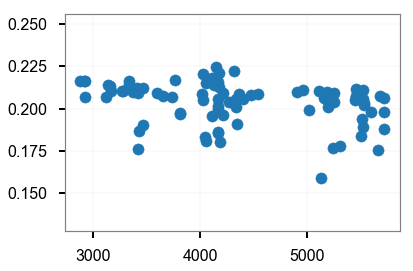

In [36]:
plt.scatter(gbr_df["age"], gbr_df["h_hat"])
#plt.hist(np.log10(gbr_df["s2_hat"]))

## Inference

In [90]:
model = gpext.GPRHet(t[:,None].astype(np.float64), h_hat[:,None], kern=gpflow.kernels.Matern32(1))
model.s2_hat = s2_hat
model.s2_hat.trainable = False

#model.likelihood.variance = 0.0
#model.likelihood.variance.trainable = False

/project/jnovembre/jhmarcus/src/miniconda3/envs/gp_env/lib/python3.6/site-packages/gpflow/densities.py:89: UserWarning: Shape of x must be 2D at computation.
  warnings.warn('Shape of x must be 2D at computation.')


In [91]:
opt = gpflow.train.ScipyOptimizer()
opt.minimize(model)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -259.882898
  Number of iterations: 39
  Number of functions evaluations: 51


INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
  Objective function value: -259.882898
  Number of iterations: 39
  Number of functions evaluations: 51


In [92]:
xx = np.array(list(range(6000))).reshape(6000, 1)
mu_pt, var_pt = model.predict_y(t[:,None].astype(np.float64))
mu, var = model.predict_y(xx)

## Critique

Text(0,0.5,'Exp Het')

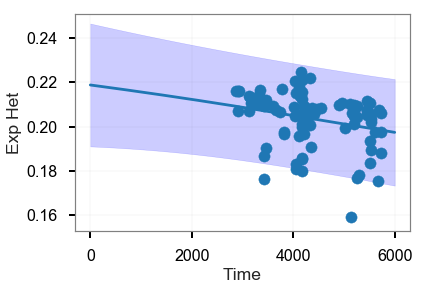

In [93]:
plt.plot(mu)
plt.fill_between(xx[:,0], mu[:,0] -  2 * np.sqrt(var[:,0]), 
                 mu[:,0] + 2 * np.sqrt(var[:,0]), 
                 color="blue", 
                 alpha=0.2)
plt.scatter(t, h_hat)
plt.xlabel("Time");
plt.ylabel("Exp Het")

In [87]:
model.likelihood.variance.value

array(0.00013771)